In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from utils import FeatureTransformer, plot_running_avg

In [2]:
class BaseModel:
    def __init__(self, D, learning_rate=0.01):
        self.W = np.random.randn(D) / np.sqrt(D)
        self.lr = learning_rate
        
    def partial_fit(self, X, y, eligibility):
        self.W += self.lr*(y - X.dot(self.W))*eligibility
        
    def predict(self, X):
        X = np.array(X)
        return X.dot(self.W)

In [3]:
class Model:
    def __init__(self, env, feature_transformer, learning_rate):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        self.lr = learning_rate
        
        sample_feature = feature_transformer.transform([env.reset()])
        D = sample_feature.shape[1]
        
        for i in range(env.action_space.n):
            model = BaseModel(D, self.lr)
            self.models.append(model)
            
        self.eligibilities = np.zeros((env.action_space.n, D))
            
    def reset(self):
        self.eligibilities = np.zeros_like(self.eligibilities)
            
    def predict(self, state):
        X = self.feature_transformer.transform([state])
        result = np.stack([model.predict(X) for model in self.models]).T
        return result
    
    def update(self, state, action, G, gamma, lambda_):
        X = self.feature_transformer.transform([state])
        """print(X.shape)
        print(X)
        print('SPACE')
        print(X[0])
        print('SPACE SPACE')
        print(self.eligibilities.shape)"""
        self.eligibilities *= gamma * lambda_
        self.eligibilities[action] += X[0]
        self.models[action].partial_fit(X[0], G, self.eligibilities[action])
        
    def sample_action(self, state, epsilon):
        if np.random.random() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(state))

In [4]:
def play_one(model, env, epsilon, gamma, lambda_):
    obs = env.reset()
    done = False
    total_r = 0
    iters = 0
    #model.reset()
    
    while not done and iters < 10000:
        action = model.sample_action(obs, epsilon)
        prev_obs = obs
        obs, reward, done, _ = env.step(action)
        
        if done:
            reward = -200
            
        total_r += reward
        
        G = reward + gamma * np.max(model.predict(obs)[0])
        
        model.update(prev_obs, action, G, gamma, lambda_)
        
        if reward == 1:
            total_r += reward
            
        iters += 1
    
    return total_r, iters

In [5]:
env = gym.make('CartPole-v0')
learning_rate = 0.1
gamma = 0.999
lambda_ = 0.7
N = 2000

Episode: 0 	Total Reward: -176.0 	 Epsilon: 1.0
Episode: 100 	Average Reward of Prev 100 Episodes: -129.08 	 Epsilon: 0.01
Episode: 200 	Average Reward of Prev 100 Episodes: 46.4 	 Epsilon: 0.01
Episode: 300 	Average Reward of Prev 100 Episodes: 95.52 	 Epsilon: 0.01
Episode: 400 	Average Reward of Prev 100 Episodes: 129.24 	 Epsilon: 0.01
Episode: 500 	Average Reward of Prev 100 Episodes: 153.14 	 Epsilon: 0.01
Episode: 600 	Average Reward of Prev 100 Episodes: 152.38 	 Epsilon: 0.01
Episode: 700 	Average Reward of Prev 100 Episodes: 150.64 	 Epsilon: 0.01
Episode: 800 	Average Reward of Prev 100 Episodes: 183.16 	 Epsilon: 0.01
Episode: 900 	Average Reward of Prev 100 Episodes: 198.0 	 Epsilon: 0.01
Episode: 1000 	Average Reward of Prev 100 Episodes: 196.14 	 Epsilon: 0.01
Episode: 1100 	Average Reward of Prev 100 Episodes: 198.0 	 Epsilon: 0.01
Episode: 1200 	Average Reward of Prev 100 Episodes: 196.38 	 Epsilon: 0.01
Episode: 1300 	Average Reward of Prev 100 Episodes: 197.82 	 Epsi

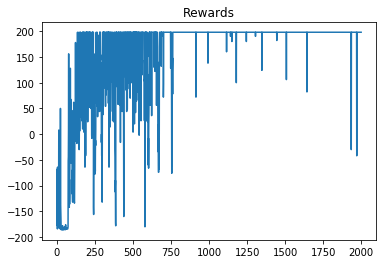

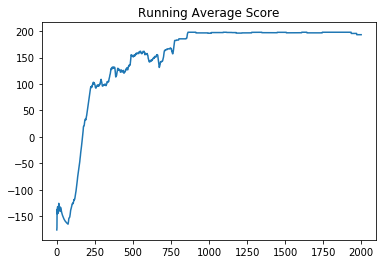

In [6]:
feat_transformer = FeatureTransformer(env)
model = Model(env, feat_transformer, learning_rate)

total_R = np.empty(N)
total_iters = 0

for n in range(N):
    eps = 0.01 + 0.99*np.exp(-0.5*n)
    #eps = 1.0 / np.sqrt(n+1)
    total_r, iters = play_one(model, env, eps, gamma, lambda_)
    total_R[n] = total_r
    total_iters += iters
    
    if n % 100 == 0:
        if n != 0:
            print('Episode: {} \tAverage Reward of Prev 100 Episodes: {} \t Epsilon: {}'.format(n,
                                                                                                total_R[n-100:n].mean(),
                                                                                                eps))
        else:
            print('Episode: {} \tTotal Reward: {} \t Epsilon: {}'.format(n,
                                                                         total_r,
                                                                         eps))

print('Average reward for last 100 episodes: ', total_R[-100:].mean())
print('Total steps: ', total_iters)

plt.plot(total_R)
plt.title('Rewards')
plt.show()

plot_running_avg(total_R)